# Kinetic Mechanism Pathway Analyzer

Han, Kehang (hkh12@mit.edu)

This analyzer takes reaction ROP file (e.g. Chemkin ckcsv file), builds a reaction network, helps answer

- if the mechanism has certain pathway (from start species to end species)

- what is the biggest flux from/towards a certain species

In [2]:
from rmgpy.rmg.model import CoreEdgeReactionModel
from rmgpy.chemkin import loadChemkinFile
import os

In [3]:
# chemkin model name
mech = 'pdd_2014_a3ene_c11'

In [4]:
path = os.path.abspath('../')
mechPath = path + '/data/' + mech
chemkinPath= mechPath + '/chem.inp'
dictionaryPath = mechPath + '/species_dictionary.txt'

model = CoreEdgeReactionModel()
model.core.species, model.core.reactions = loadChemkinFile(chemkinPath,dictionaryPath)

In [5]:
# generate paris for reactions that don't have flux pairs
# if you dont have annotated chemkin files, some info is missing -> just run it

for rxn in model.core.reactions:
    if not rxn.pairs: rxn.generatePairs()

## Create networkx Graph

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
from extractInfoFromckcsv import getConcentrationDictFromCKCSV, getROPFromCKCSV, getFluxGraphEdgesDict
from rmgpy.chemkin import getSpeciesIdentifier
from IPython.display import display
import numpy as np
%matplotlib inline

### s1: prepare a dict for graph edges

In [7]:
ckcsvPath= mechPath + '/CKSoln.ckcsv'
firstColDict, spc_mf_dict = getConcentrationDictFromCKCSV(ckcsvPath)

first_col_dict, spc_total_rop_dict, spc_rop_dict = getROPFromCKCSV(ckcsvPath)

In [8]:
graph_edges_dict = getFluxGraphEdgesDict(spc_rop_dict, model.core.reactions)

In [9]:
graph_edges_dict_simple = {}
for pair in graph_edges_dict:
    node1 = getSpeciesIdentifier(pair[0])
    node2 = getSpeciesIdentifier(pair[1])
    graph_edges_dict_simple[(node1, node2)] = graph_edges_dict[pair]

### s2: create DiGraph()

In [10]:
time_investigated = 0.5 # hour
# find the closest time step
timepoint_index = (np.abs(firstColDict['Time_(sec)']-time_investigated*3600)).argmin()

In [11]:
G = nx.DiGraph()
for pair in graph_edges_dict:
    node1 = getSpeciesIdentifier(pair[0])
    node2 = getSpeciesIdentifier(pair[1])
    e_rawdata = graph_edges_dict[pair]
    total_flux = 0
    for rxn in e_rawdata:
        total_flux += e_rawdata[rxn][timepoint_index]
    if total_flux >= 0:
        G.add_edge(node2, node1, {"total_flux":total_flux}) # in G, positive means production of node1
    else: 
        G.add_edge(node1, node2, {"total_flux":-total_flux}) # in G, negative means consumption of node1      

### s3: find paths (with known target)

In [18]:
# source: starting reactant
# target: product you want to find
# If cutoff=5, shows the maximum 5 steps

paths = list(nx.all_simple_paths(G, source="PDD(1)", target="STYRENE(3)", cutoff=2))
print len(paths)

1


#### sort out most sginificant path

In [19]:
path_fluxes = []
for i, path in enumerate(paths):
#     print i, path
    path_steps = len(path) - 1
    fluxes = [G[path[step]][path[step+1]]['total_flux'] for step in range(path_steps) ]
    path_fluxes.append(min(fluxes))
sorted_path_fluxes = sorted(path_fluxes)
print sorted_path_fluxes[-1], path_fluxes.index(sorted_path_fluxes[-1])

1.939969e-09 0


#### visualize the path of interest



**********Step0: PDD(1) --> RAD1(14): 9.97883213637e-09*************


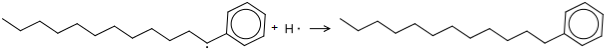

rxn#2641: RAD1(14) + [H](83) <=> PDD(1)


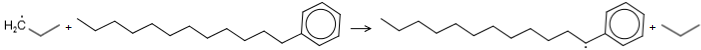

rxn#147(1/95 H_Abs): PROPYL(49) + PDD(1) <=> RAD1(14) + C3(28)


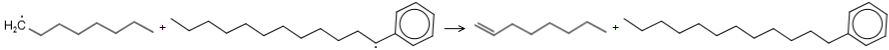

rxn#371(1/31 Disp): OCTYL(54) + RAD1(14) <=> C8ene(43) + PDD(1)


**********Step1: RAD1(14) --> STYRENE(3): 1.939969e-09*************


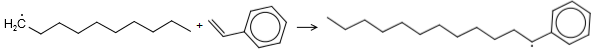

rxn#23: DECYL(56) + STYRENE(3) <=> RAD1(14)


In [21]:
# fluxes are sum of every fluxes for possible ways from source -> certain intermediate / product
# below that step are the sample reactons for that step

path = paths[0]
path_steps = len(path) - 1
for step in range(path_steps):
    step_pair = (path[step], path[step+1])
    h_abs_rxns = []
    disp_rxns = []
    
    print "\n"
    print "**********Step{0}: {1} --> {2}: {3}*************".\
    format(step, step_pair[0], step_pair[1], G[step_pair[0]][step_pair[1]]['total_flux'])
    if step_pair not in graph_edges_dict_simple:
        step_pair = (step_pair[1], step_pair[0])
                
    for rxn in graph_edges_dict_simple[step_pair]:
        if rxn.family == "H_Abstraction":
            h_abs_rxns.append(rxn)
        elif rxn.family == "Disproportionation":
            disp_rxns.append(rxn)
        else:
            display(rxn)
            print "rxn#{0}: ".format(rxn.index) + str(rxn)
    if len(h_abs_rxns) > 0: 
        display(h_abs_rxns[0])
        print "rxn#{0}(1/{1} H_Abs): ".format(h_abs_rxns[0].index, len(h_abs_rxns)) + str(h_abs_rxns[0])
    if len(disp_rxns) > 0: 
        display(disp_rxns[0])
        print "rxn#{0}(1/{1} Disp): ".format(disp_rxns[0].index, len(disp_rxns)) + str(disp_rxns[0])

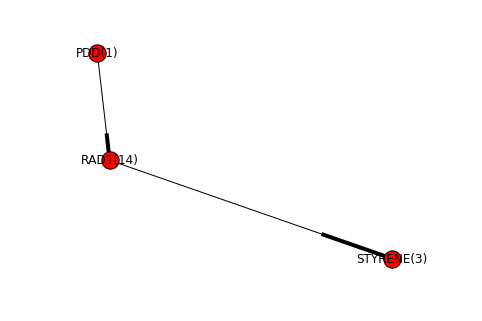

In [23]:
newG = G.subgraph(paths[0])
nx.draw(newG, with_labels=True)

### s4: find major decomposition paths (without known targets)



**********Step0: PDD(1) --> RAD3(16): 2.83460925077e-08*************


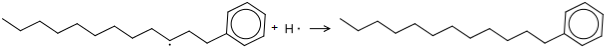

R_Recombination
rxn#2638: RAD3(16) + [H](83) <=> PDD(1): 3.651247e-19 


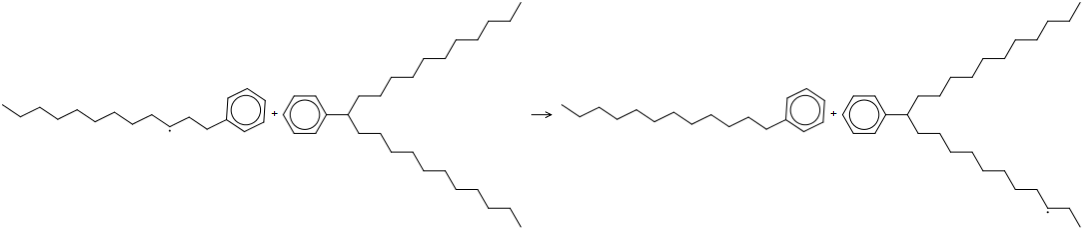

rxn#6877(1/95 H_Abs): RAD3(16) + CCCCCCCCCCCC(CCCCCCCCCCC)c1ccccc1(373) <=> PDD(1) + CC[CH]CCCCCCCCC(CCCCCCCCCCC)c1ccccc1(20056)


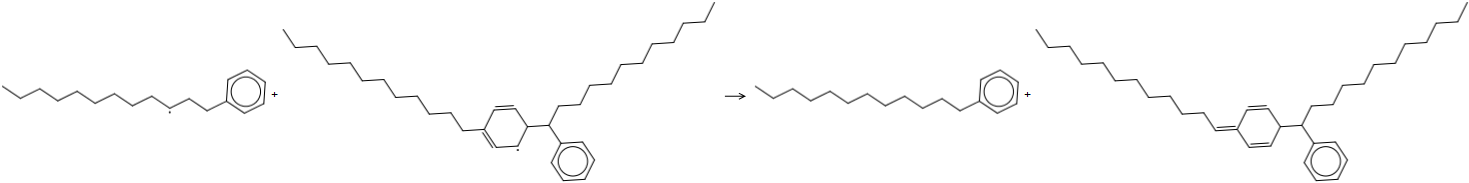

rxn#1480(1/31 Disp): RAD3(16) + CCCCCCCCCCCCC1C=CC([CH]C=1)C(CCCCCCCCCCC)c1ccccc1(150) <=> PDD(1) + CCCCCCCCCCCC=C1C=CC(C=C1)C(CCCCCCCCCCC)c1ccccc1(309)


In [31]:
source = "PDD(1)"
depth = 1 # one step
current_node = source
path_top_list = [0, 0] # [0]:find the biggest [1]: find the second largest, [2]: the thrid largest
for step in range(depth):
    print "\n"    
    nextNode_flux_list = [(next_node, G[current_node][next_node]['total_flux']) for next_node in G[current_node]]
    sorted_nextNode_flux_list = sorted(nextNode_flux_list, key=lambda tup: -tup[1])
    
    # choose the top one as next node
    tup = sorted_nextNode_flux_list[path_top_list[step]]
    next_node = tup[0]
    step_flux = tup[1]
    
    print "**********Step{0}: {1} --> {2}: {3}*************".\
    format(step, current_node, next_node, step_flux)
    
    step_pair = (current_node, next_node)
    if step_pair not in graph_edges_dict_simple:
        step_pair = (next_node, current_node)
    
    h_abs_rxns = []
    disp_rxns = []
    for rxn in graph_edges_dict_simple[step_pair]:
        if rxn.family == "H_Abstraction":
            h_abs_rxns.append(rxn)
        elif rxn.family == "Disproportionation":
            disp_rxns.append(rxn)
        else:
            display(rxn)
            print rxn.family
            print "rxn#{0}: {1}: {2} ".format(rxn.index, str(rxn), graph_edges_dict_simple[step_pair][rxn][timepoint_index])
    if len(h_abs_rxns) > 0: 
        display(h_abs_rxns[0])
        print "rxn#{0}(1/{1} H_Abs): ".format(h_abs_rxns[0].index, len(h_abs_rxns)) + str(h_abs_rxns[0])
    if len(disp_rxns) > 0: 
        display(disp_rxns[0])
        print "rxn#{0}(1/{1} Disp): ".format(disp_rxns[0].index, len(disp_rxns)) + str(disp_rxns[0])
    
    current_node = next_node

('RAD3(16)', 'PDD(1)')
**********************************************************************************


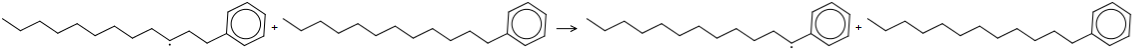

rxn#66: RAD3(16) + PDD(1) <=> RAD1(14) + PDD(1): 5.640483e-09 


In [33]:
# what is the reaction with the flux greater than the threshold
# it will always use the last stpe if multi-step was selected
# if no reactions is drawn, it means there's no additional step than the one shown?

print step_pair
for rxn in h_abs_rxns + disp_rxns:
    flux = graph_edges_dict_simple[step_pair][rxn][timepoint_index]
    # 5e-9 -> threshold reactions
    if abs(flux) > 5e-9:
        print "**********************************************************************************"
        display(rxn) 
        print "rxn#{0}: {1}: {2} ".format(rxn.index, str(rxn), flux) # positive flux means production of pair node1

### s5: find major generation paths (without known sources)



**********Step0: STYRENE(3) <-- RAD1(14): 1.939969e-09*************


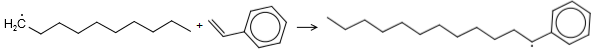

rxn#23: DECYL(56) + STYRENE(3) <=> RAD1(14)


In [34]:
target = "STYRENE(3)"
depth = 1
current_node = target
path_top_list = [0, 0]
for step in range(depth):
    print "\n"
    prev_nodes = []
    for node1 in G:
        if current_node in G[node1]:
            prev_nodes.append(node1)
    prevNode_flux_list = [(prev_node, G[prev_node][current_node]['total_flux']) for prev_node in prev_nodes]
    sorted_prevNode_flux_list = sorted(prevNode_flux_list, key=lambda tup: -tup[1])
    
    # choose the top one as next node
    tup = sorted_prevNode_flux_list[path_top_list[step]]
    prev_node = tup[0]
    step_flux = tup[1]
    
    print "**********Step{0}: {1} <-- {2}: {3}*************".\
    format(step, current_node, prev_node, step_flux)
    
    step_pair = (prev_node, current_node)
    if step_pair not in graph_edges_dict_simple:
        step_pair = (current_node, prev_node)
    
    h_abs_rxns = []
    disp_rxns = []
    for rxn in graph_edges_dict_simple[step_pair]:
        if rxn.family == "H_Abstraction":
            h_abs_rxns.append(rxn)
        elif rxn.family == "Disproportionation":
            disp_rxns.append(rxn)
        else:
            display(rxn)
            print "rxn#{0}: ".format(rxn.index) + str(rxn)
    if len(h_abs_rxns) > 0: 
        display(h_abs_rxns[0])
        print "rxn#{0}(1/{1} H_Abs): ".format(h_abs_rxns[0].index, len(h_abs_rxns)) + str(h_abs_rxns[0])
    if len(disp_rxns) > 0: 
        display(disp_rxns[0])
        print "rxn#{0}(1/{1} Disp): ".format(disp_rxns[0].index, len(disp_rxns)) + str(disp_rxns[0])
    
    current_node = prev_node